# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = 'ReacherBrain'
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
#buffer = ReplayBuffer(300)

env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
counter = 0
while True:
    counter += 1
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
#    buffer.push(states, actions, rewards, next_states, dones)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
counter

Total score (averaged over agents) this episode: 0.1304999970830977


1001

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
import gym
import random
import torch
import numpy as np
from collections import namedtuple, deque
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.999             # for soft update of target parameters
LR_ACTOR = 5e-4         # learning rate of the actor
LR_CRITIC = 5e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0      # L2 weight decay
EPSILON = 1.0           # explore->exploit noise process added to act step
EPSILON_DECAY = 0.99    # decay rate for noise process
UPDATE_EVERY = 1        # how often to update the target network
LEARN_NUM = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, fc_units=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        return F.tanh(self.fc2(x))


class Critic(nn.Module):
    def __init__(self, state_size, action_size, fcs1_units=256, fc2_units=256, fc3_units=128):
        super(Critic, self).__init__()
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)
    

class Agent():
    def __init__(self, state_size, action_size, num_agents):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = EPSILON
        self.t_step = 0
        # Actor Network (w/ Target Network)
        self.actor = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr = LR_ACTOR)
        # Critic Network (w/ Target Network)
        self.critic = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr = LR_CRITIC, weight_decay=WEIGHT_DECAY)
        # Noise process
        self.noise = OUNoise((num_agents, action_size))
        # Replay memory
        self.buffer = ReplayBuffer(buffer_size = BUFFER_SIZE)

    def get_action(self, state, add_noise = True):
        state_tensor = torch.from_numpy(state).float().to(device)

        self.actor.eval()
        with torch.no_grad():
            action = self.actor(state_tensor).detach().cpu().numpy()
        self.actor.train()
        
        if add_noise:
            action += self.epsilon * self.noise.sample()

        return np.clip(action, -1, 1)

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        # ---------------------------- update critic ---------------------------- #
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        Q_expected = self.critic(states, actions)
        
        loss_fn = nn.MSELoss()
        critic_loss = loss_fn(Q_expected, Q_targets.detach())
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # ---------------------------- update actor ---------------------------- #
        actions_pred = self.actor(states)
        actor_loss = -self.critic(states, actions_pred).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()     
        
    def soft_update(self, model, target_model, tau):
        for target_param, param in zip(target_model.parameters(), model.parameters()):
            target_param.data.copy_(tau*target_param.data + (1.0-tau)*param.data)
            

    def step(self, state, action, reward, next_state, done):
        self.buffer.push(state, action, reward, next_state, done)
        
        if len(self.buffer)> BATCH_SIZE:
            self.t_step = self.t_step + 1
            for _ in range(LEARN_NUM):
                experiences = self.buffer.sample(BATCH_SIZE)
                self.learn(experiences, GAMMA)
            
            if (self.t_step % UPDATE_EVERY) == 0:
                self.soft_update(self.critic, self.critic_target, TAU)
                self.soft_update(self.actor, self.actor_target, TAU)
                self.t_step = 0

    def reset(self):
        self.noise.reset()
        self.epsilon = self.epsilon * EPSILON_DECAY
        

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state


class ReplayBuffer(object):
    def __init__(self, buffer_size) :
        self.memory = deque(maxlen = buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def push(self, states, actions, rewards, next_states, dones):
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.append(self.experience(state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.memory, k = batch_size)
        batch = self.experience(*zip(*samples))
        states = torch.from_numpy(np.asarray(batch.state)).float().to(device)
        actions = torch.from_numpy(np.asarray(batch.action)).float().to(device) # discrete action space
        rewards = torch.from_numpy(np.asarray(batch.reward)).float().view(-1,1).to(device)
        next_states = torch.tensor(np.asarray(batch.next_state)).float().to(device)
        # 0 for note finished, 1 for terminated
        dones = torch.tensor([1 if done else 0 for done in batch.done]).float().view(-1,1).to(device)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

Episode 1	Average Score: 0.80
Episode 2	Average Score: 0.53
Episode 3	Average Score: 0.67
Episode 4	Average Score: 0.89
Episode 5	Average Score: 0.94
Episode 6	Average Score: 1.11
Episode 7	Average Score: 1.36
Episode 8	Average Score: 1.47
Episode 9	Average Score: 1.68
Episode 10	Average Score: 2.43
Episode 11	Average Score: 2.80
Episode 12	Average Score: 3.33
Episode 13	Average Score: 3.86
Episode 14	Average Score: 5.85
Episode 15	Average Score: 8.28
Episode 16	Average Score: 11.13
Episode 17	Average Score: 16.23
Episode 18	Average Score: 15.98
Episode 19	Average Score: 19.08
Episode 20	Average Score: 22.76
Episode 21	Average Score: 26.67
Episode 22	Average Score: 26.92
Episode 23	Average Score: 30.17

model saved!
Episode 24	Average Score: 32.33

model saved!
Episode 25	Average Score: 33.07

model saved!
Episode 26	Average Score: 34.64

model saved!
Episode 27	Average Score: 35.14

model saved!
Episode 28	Average Score: 35.34

model saved!
Episode 29	Average Score: 36.87

model saved

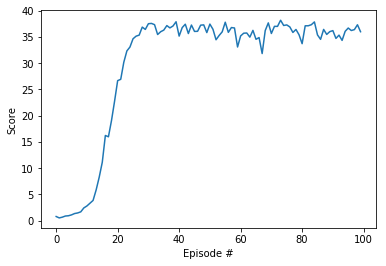

In [8]:
agent = Agent(state_size, action_size, num_agents)  

n_episodes = 100

score_list = []
best_score = 30.0
for i_episode in range(1, n_episodes+1):
    
    scores = np.zeros(num_agents)                         
    agent.reset()
    env_info = env.reset(train_mode=True)[brain_name]      
    states = env_info.vector_observations                   
    
    while True:
        
        actions = agent.get_action(states)
        env_info = env.step(actions)[brain_name]    
        
        next_states = env_info.vector_observations         
        rewards = env_info.rewards                        
        dones = env_info.local_done    
        
        agent.step(states, actions, rewards, next_states, dones)
        
        states = next_states
        scores += rewards        
        
        if np.any(dones):                                 
            break

    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
    score_list.append(np.mean(scores))
    
    if np.mean(scores) >= best_score:
        print('\nmodel saved!')
        torch.save(agent.actor.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic.state_dict(), 'checkpoint_critic.pth')
        best_score  = np.mean(scores)
    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(score_list)), score_list)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [19]:
env.close()

### 5. Watch trained agent

In [3]:
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
brain_name = 'ReacherBrain'
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [13]:
agent = Agent(state_size, action_size, num_agents)  

agent.actor.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic.load_state_dict(torch.load('checkpoint_critic.pth'))

In [15]:
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
env_info = env.reset(train_mode=True)[brain_name]      
states = env_info.vector_observations
while True:
    actions = agent.get_action(states, add_noise = False) # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    
    states = next_states                               # roll over states to next time step
    scores += env_info.rewards                         # update the score (for each agent)
    
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 37.8899991530925


In [ ]:
env.close()

### 6.Ideas for Future Work

- Implement Proximal Policy Optimization (PPO) for better performance
- try prioritized experience replay
- try N-step returns